# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных

**Признаки**

- *DateCrawled* — дата скачивания анкеты из базы


- *VehicleType* — тип автомобильного кузова


- *RegistrationYear* — год регистрации автомобиля


- *Gearbox* — тип коробки передач


- *Power* — мощность (л. с.)


- *Model* — модель автомобиля


- *Kilometer* — пробег (км)


- *RegistrationMonth* — месяц регистрации автомобиля


- *FuelType* — тип топлива


- *Brand* — марка автомобиля


- *NotRepaired* — была машина в ремонте или нет


- *DateCreated* — дата создания анкеты


- *NumberOfPictures* — количество фотографий автомобиля


- *PostalCode* — почтовый индекс владельца анкеты (пользователя)


- *LastSeen* — дата последней активности пользователя


**Целевой признак**

- *Price* — цена (евро)

## Подготовка данных

Подключим нужные библиотеки, прочитаем файлы и посмотрим на их значения, размеры и типы данных.

In [1]:
!pip install lightgbm

import pandas as pd
import numpy as np

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor


from sklearn.feature_selection import RFE

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from scipy import stats as st
from scipy.stats import levene


from IPython.display import display
pd.set_option('display.float_format', '{:.2f}'.format)
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

Defaulting to user installation because normal site-packages is not writeable


In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [3]:
df.info()
display(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


- Столбцы DateCrawled, DateCreated, PostalCode, LastSeen считаю не влияющими. Удаляем.


- Много пропусков в колонке NotRepaired — была машина в ремонте или нет. Заменим на "unknown". Однако, для достижения более точного результата, **стоит поговорить с заказчиком и разработчиками**: может, информация по пропускам есть.


- Также немало пропусков в VehicleType, FuelType, Gearbox, Model. Причем количество пропусков в Gearbox и Model очень схоже. Посмотрим подробнее эти пропуски.


- Посмотреть нули и артефакты в каждом признаке (построить гистограммы).


- Посмотреть уникальные значения. Например, в типе топлива возникает вопрос: petrol и gasoline - это один и тот же тип или всё таки их стоит различать?

In [4]:
print('Число дубликатов в обучающей выборке:', df.duplicated().sum())
df = df.drop_duplicates().reset_index(drop
= True)

Число дубликатов в обучающей выборке: 4


Посмотрим на последний год активности

In [5]:
df['LastSeen'].max()

'2016-04-07 14:58:51'

Всё, что выше этой даты, - точно артефакты, которые стоит удалить.

In [6]:
df = df[df['LastSeen'] < '2016-04-07 14:58:51']

In [7]:
df.drop(columns=['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen'], inplace=True)

In [8]:
df[(df['Gearbox'].isna()) & (df['Model'].isna()) & (df['VehicleType'].isna()) & (df['FuelType'].isna())].info()
display(df[(df['Gearbox'].isna()) & (df['Model'].isna()) & (df['VehicleType'].isna()) & (df['FuelType'].isna())])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2392 entries, 306 to 354361
Data columns (total 12 columns):
Price                2392 non-null int64
VehicleType          0 non-null object
RegistrationYear     2392 non-null int64
Gearbox              0 non-null object
Power                2392 non-null int64
Model                0 non-null object
Kilometer            2392 non-null int64
RegistrationMonth    2392 non-null int64
FuelType             0 non-null object
Brand                2392 non-null object
NotRepaired          155 non-null object
NumberOfPictures     2392 non-null int64
dtypes: int64(6), object(6)
memory usage: 242.9+ KB


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,NumberOfPictures
306,200,NaN,2009,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,0
522,0,NaN,2000,NaN,0,NaN,150000,0,NaN,volvo,NaN,0
538,2600,NaN,2005,NaN,0,NaN,125000,0,NaN,chevrolet,NaN,0
552,50,NaN,1985,NaN,0,NaN,150000,11,NaN,trabant,NaN,0
622,0,NaN,1111,NaN,0,NaN,5000,0,NaN,opel,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
353723,1,NaN,2000,NaN,0,NaN,150000,0,NaN,bmw,NaN,0
354069,1750,NaN,1995,NaN,0,NaN,100000,12,NaN,sonstige_autos,NaN,0
354079,0,NaN,2000,NaN,0,NaN,150000,0,NaN,sonstige_autos,NaN,0
354158,1500,NaN,1995,NaN,0,NaN,150000,0,NaN,volkswagen,NaN,0


Получили 2392 автомобиля с пропусками во всех четырёх рассматриваемых позициях. Беглый взгляд показал, что это не единственные проблемы с этими объектами: у них нет фото, нули в месяце регистрации и мощности, нет указания на то, была ли машина в ремонте, странные цены. Предлагаю их полностью удалить из рассмотрения.

In [9]:
bad_objects_index = df[(df['Gearbox'].isna()) & (df['Model'].isna()) & (df['VehicleType'].isna()) & (df['FuelType'].isna())].index
print(bad_objects_index)

Int64Index([   306,    522,    538,    552,    622,   1331,   1345,   1374,
              1396,   1459,
            ...
            352926, 352985, 353100, 353298, 353580, 353723, 354069, 354079,
            354158, 354361],
           dtype='int64', length=2392)


In [10]:
df.drop(bad_objects_index, inplace=True)
df.reset_index(drop=True, inplace=True)
display(df)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,NumberOfPictures
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,0
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,0
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,0
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...
351967,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,0
351968,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,0
351969,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,0
351970,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351972 entries, 0 to 351971
Data columns (total 12 columns):
Price                351972 non-null int64
VehicleType          316874 non-null object
RegistrationYear     351972 non-null int64
Gearbox              334531 non-null object
Power                351972 non-null int64
Model                334659 non-null object
Kilometer            351972 non-null int64
RegistrationMonth    351972 non-null int64
FuelType             321469 non-null object
Brand                351972 non-null object
NotRepaired          283055 non-null object
NumberOfPictures     351972 non-null int64
dtypes: int64(6), object(6)
memory usage: 32.2+ MB


Посмотрим уникальные значения категориальных признаков.

In [12]:
df['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [13]:
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [14]:
df['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [15]:
df['NotRepaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [16]:
df['NumberOfPictures'].unique()

array([0])

- Поиск в интернете показал, что petrol и gasoline не стоит различать, как разные виды топлива. Переименуем gasoline в petrol. Пропуски заменим на unknown.


- Фото нет ни у одного объекта. Удаляем этот признак.

In [17]:
df.drop(columns=['NumberOfPictures'], inplace=True)
df['NotRepaired'] = df['NotRepaired'].fillna('unknown')
df['Gearbox'] = df['Gearbox'].fillna('unknown')
df['VehicleType'] = df['VehicleType'].fillna('unknown')
df['FuelType'] = df['FuelType'].fillna('unknown')
df['FuelType'] = df['FuelType'].replace('gasoline', 'petrol')
df['Model'] = df['Model'].fillna('unknown')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351972 entries, 0 to 351971
Data columns (total 11 columns):
Price                351972 non-null int64
VehicleType          351972 non-null object
RegistrationYear     351972 non-null int64
Gearbox              351972 non-null object
Power                351972 non-null int64
Model                351972 non-null object
Kilometer            351972 non-null int64
RegistrationMonth    351972 non-null int64
FuelType             351972 non-null object
Brand                351972 non-null object
NotRepaired          351972 non-null object
dtypes: int64(5), object(6)
memory usage: 29.5+ MB


### Анализ численных признаков

Построим гистограммы признаков. К численным пока припишем и целевой. Это на время исследования выбросов, так удобнее.

In [19]:
numeric = ['RegistrationYear', 'Power', 'Kilometer', 'Price']
title_xlabel_of_numeric = ['Год регистрации', 'Лошадиные силы', 'Пробег(км)', 'Цена (евро)']

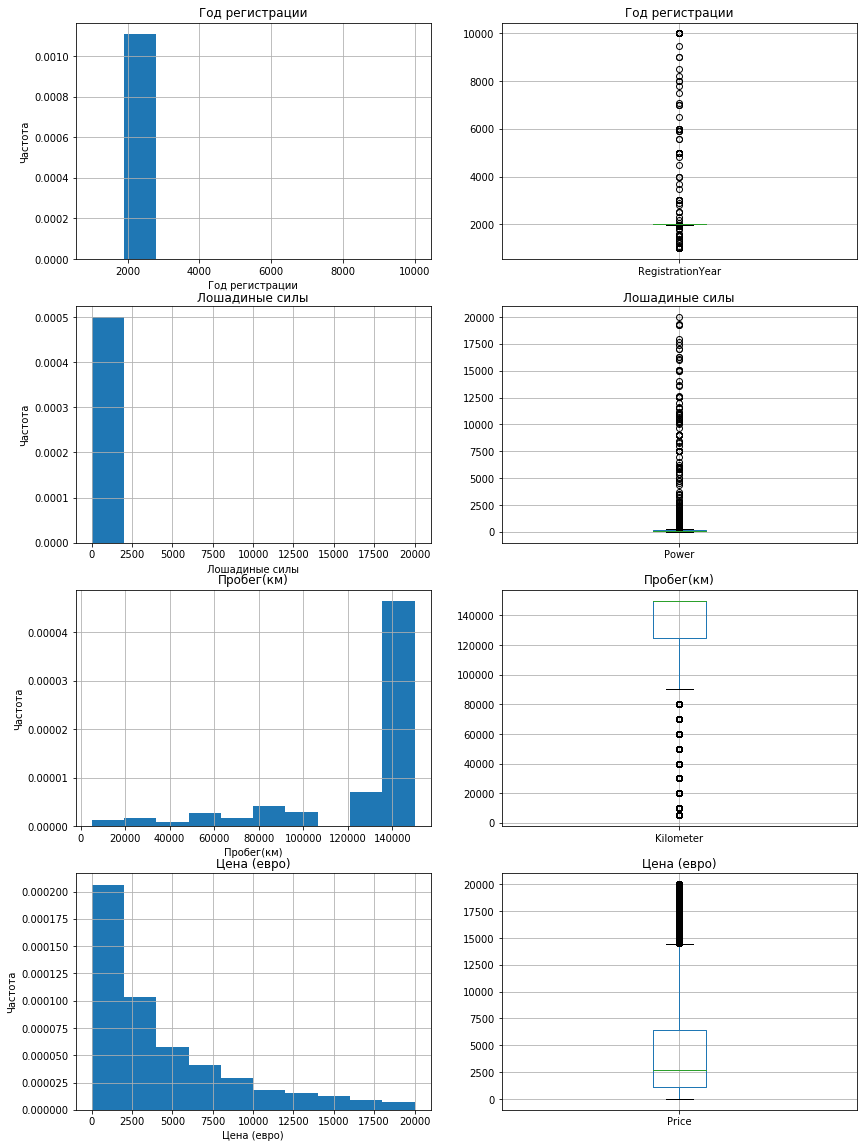

In [20]:
fig, axes = plt.subplots(len(numeric), 2, figsize=(14,20))
for i in range(len(numeric)):
    df[numeric[i]].hist(bins=10, density=True,figure=fig, ax=axes[i][0]).set_title(title_xlabel_of_numeric[i])
    df.boxplot(column=numeric[i], ax=axes[i][1]).set_title(title_xlabel_of_numeric[i])
    axes[i][0].set_xlabel(title_xlabel_of_numeric[i])
    axes[i][0].set_ylabel('Частота')

Видно, что в данных много нереалистичных выбросов:

- Год регистрации выше 2016 удаляем.

- Максимальная мощность двигателя составляет невероятные 1600 лошадиных сил. Удалим всё, что выше этого значения.

- В пробеге выбросы хоть и есть, но можно поверить, что существуют машины, которые хотят продать даже с маленьким пробегом. Ничего не удаляем.

In [21]:
df = df[(df['RegistrationYear'] < 2022) & (df['Power'] <= 1600)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351724 entries, 0 to 351971
Data columns (total 11 columns):
Price                351724 non-null int64
VehicleType          351724 non-null object
RegistrationYear     351724 non-null int64
Gearbox              351724 non-null object
Power                351724 non-null int64
Model                351724 non-null object
Kilometer            351724 non-null int64
RegistrationMonth    351724 non-null int64
FuelType             351724 non-null object
Brand                351724 non-null object
NotRepaired          351724 non-null object
dtypes: int64(5), object(6)
memory usage: 32.2+ MB


Посмотрим ещё раз на гистограммы и диаграммы размаха.

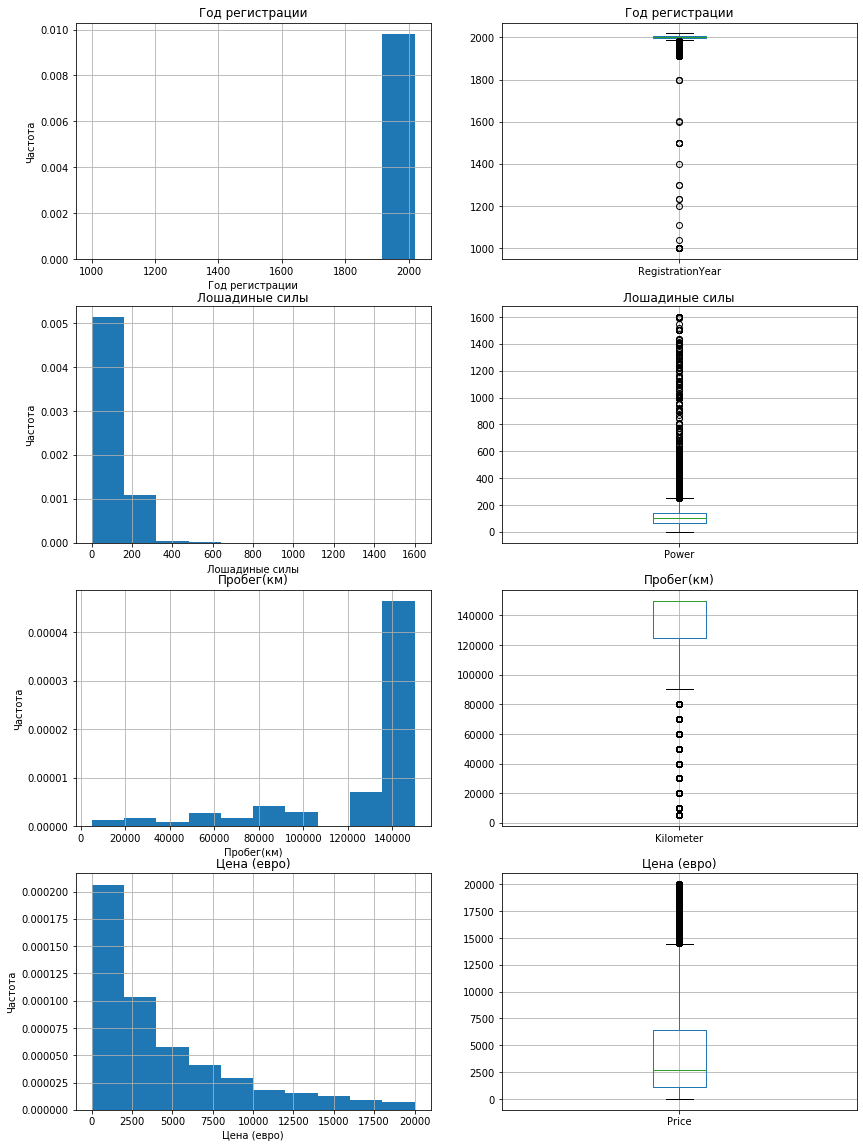

In [22]:
fig, axes = plt.subplots(len(numeric), 2, figsize=(14,20))
for i in range(len(numeric)):
    df[numeric[i]].hist(bins=10, density=True,figure=fig, ax=axes[i][0]).set_title(title_xlabel_of_numeric[i])
    df.boxplot(column=numeric[i], ax=axes[i][1]).set_title(title_xlabel_of_numeric[i])
    axes[i][0].set_xlabel(title_xlabel_of_numeric[i])
    axes[i][0].set_ylabel('Частота')

Всё равно остались нереалистичные значения. Удалим выбросы в RegistrationYear и Power, выходящие за тройной межквартильный размах

In [23]:
iqr_year = np.percentile(df['RegistrationYear'], 75) - np.percentile(df['RegistrationYear'], 25)
low_year = np.percentile(df['RegistrationYear'], 25) - 3 * iqr_year
df = df[df['RegistrationYear'] >= low_year]

iqr_power = np.percentile(df['Power'], 75) - np.percentile(df['Power'], 25)
high_power = np.percentile(df['Power'], 75) + 3 * iqr_power
df = df[df['Power'] <= high_power]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349229 entries, 0 to 351971
Data columns (total 11 columns):
Price                349229 non-null int64
VehicleType          349229 non-null object
RegistrationYear     349229 non-null int64
Gearbox              349229 non-null object
Power                349229 non-null int64
Model                349229 non-null object
Kilometer            349229 non-null int64
RegistrationMonth    349229 non-null int64
FuelType             349229 non-null object
Brand                349229 non-null object
NotRepaired          349229 non-null object
dtypes: int64(5), object(6)
memory usage: 32.0+ MB


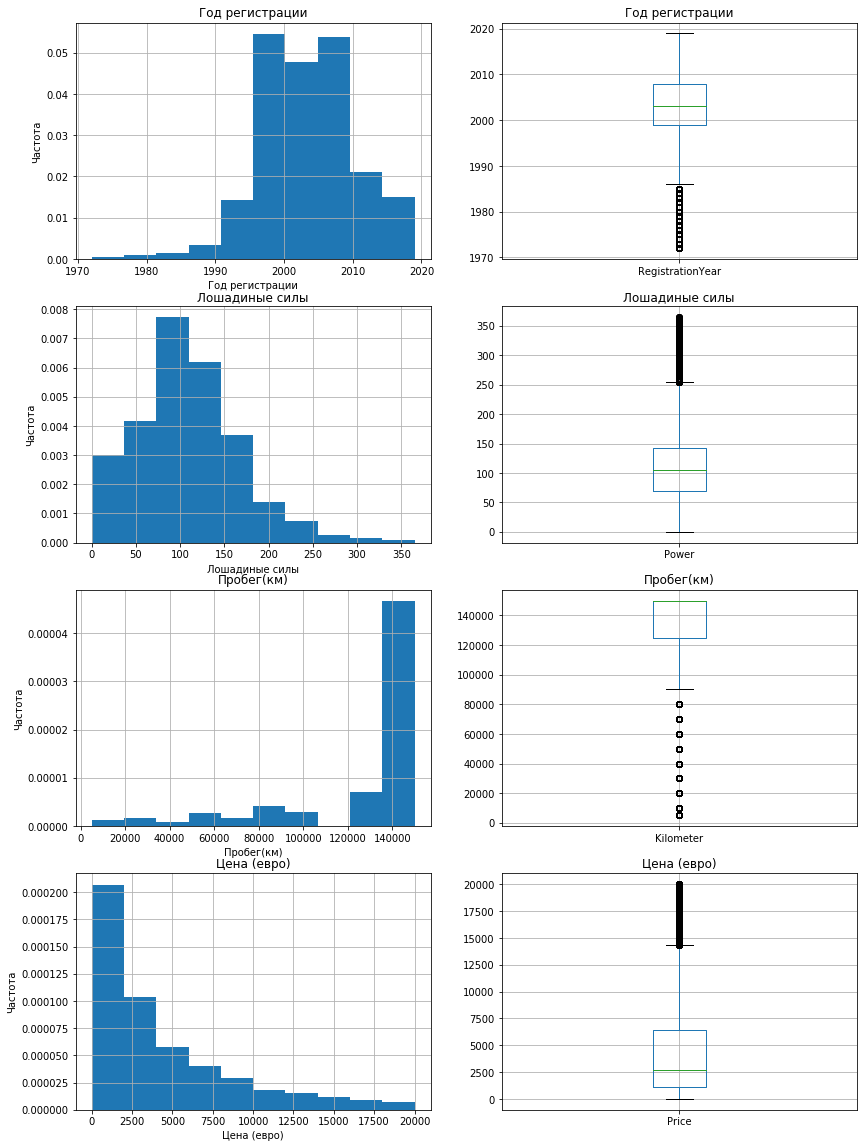

In [24]:
fig, axes = plt.subplots(len(numeric), 2, figsize=(14,20))
for i in range(len(numeric)):
    df[numeric[i]].hist(bins=10, density=True,figure=fig, ax=axes[i][0]).set_title(title_xlabel_of_numeric[i])
    df.boxplot(column=numeric[i], ax=axes[i][1]).set_title(title_xlabel_of_numeric[i])
    axes[i][0].set_xlabel(title_xlabel_of_numeric[i])
    axes[i][0].set_ylabel('Частота')

Теперь графики выглядят правдоподобно. Проверим на мультиколлинеарность.

In [25]:
corr = df[numeric].corr().reset_index().melt(id_vars = ['index'], var_name = ['index_2'])
corr = corr[(corr['value'] != 1) & (corr['index'] < corr['index_2'])].sort_values(by='value')

display(corr)

,index,index_2,value
14,Kilometer,Price,-0.35
2,Kilometer,RegistrationYear,-0.24
6,Kilometer,Power,0.07
1,Power,RegistrationYear,0.10
3,Price,RegistrationYear,0.42
13,Power,Price,0.49


Сильнокоррелирующих признаков нет.

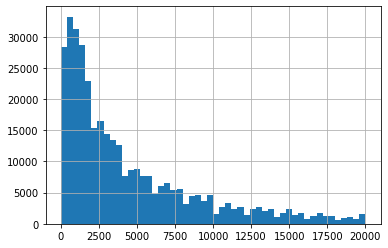

In [26]:
df['Price'].hist(bins=50)

In [27]:
df['Price'].describe()
print()
print('Граница, ниже которой получаем выбросы в цене: {:.0f}'.format(np.percentile(df['RegistrationYear'], 25) - 3 * iqr_year))


Граница, ниже которой получаем выбросы в цене: 1972


Всё же эта цена кажется вполне возможной) ограничусь 500 евро. Для улучшения точности можно детальнее посмотреть, в каком состоянии авто, которые дешевле 1972 евро и отсеять ещё.

In [28]:
print('Количество объявлений с ценой ниже $100:', len(df[df['Price'] < 500]))

Количество объявлений с ценой ниже $100: 34236


In [29]:
df = df[df['Price'] >= 500]

### Анализ категориальных признаков


Посмотрим барплоты категориальных признаков.

In [30]:
categories = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314993 entries, 1 to 351971
Data columns (total 11 columns):
Price                314993 non-null int64
VehicleType          314993 non-null object
RegistrationYear     314993 non-null int64
Gearbox              314993 non-null object
Power                314993 non-null int64
Model                314993 non-null object
Kilometer            314993 non-null int64
RegistrationMonth    314993 non-null int64
FuelType             314993 non-null object
Brand                314993 non-null object
NotRepaired          314993 non-null object
dtypes: int64(5), object(6)
memory usage: 28.8+ MB


In [32]:
#fig, axes = plt.subplots(len(categories),1, figsize=(12, len(categories)*8))
def category_barplot(category, top=1000000):
    df_pv = df.pivot_table(
    index=category, values='Price', aggfunc=['count']
    ).sort_values(by=('count', 'Price'), ascending=False)
    df_pv.columns = ['count']
    
    if len(df_pv) > top:
        df_pv = df_pv[:top]
    
    plt.figure(figsize=(16, 6)) 
    platform_barplot = sns.barplot(x=df_pv.index, y='count', ci=None, data=df_pv)\
        .set_title('Распределение числа автомобилей по признаку ' + category)
    plt.show()

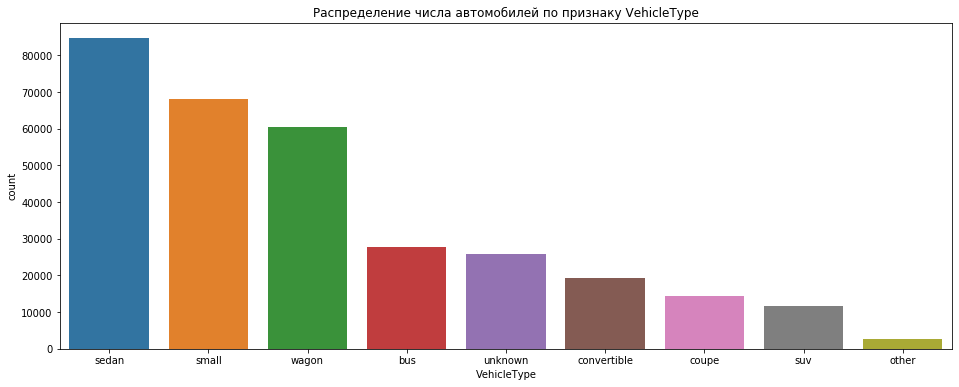

In [33]:
category_barplot('VehicleType')

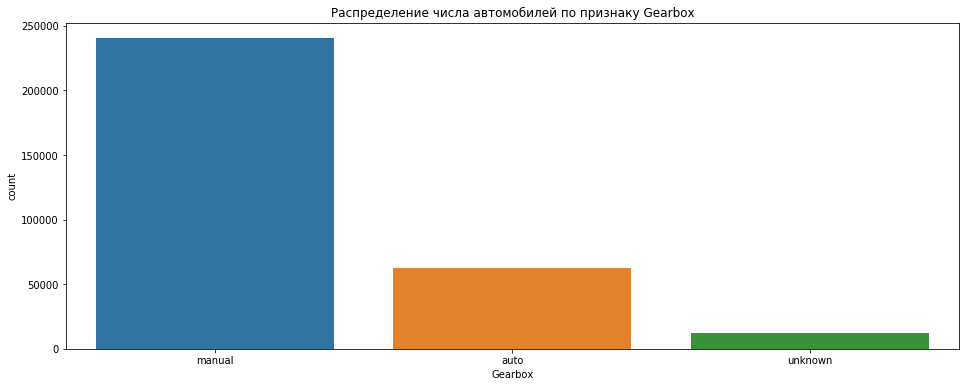

In [34]:
category_barplot('Gearbox')

Очень неравномерная разбивка с преобладанием ручной коробки передач.

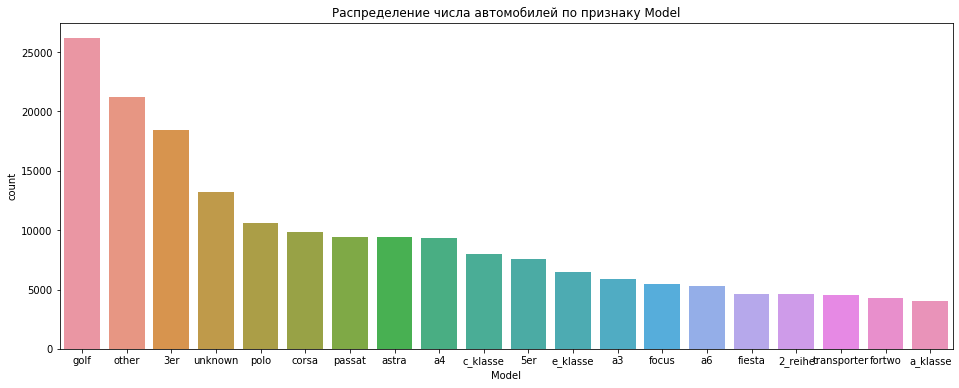

In [35]:
category_barplot('Model', 20)

Моделей очень много. На графике ограничились 20 значениями.

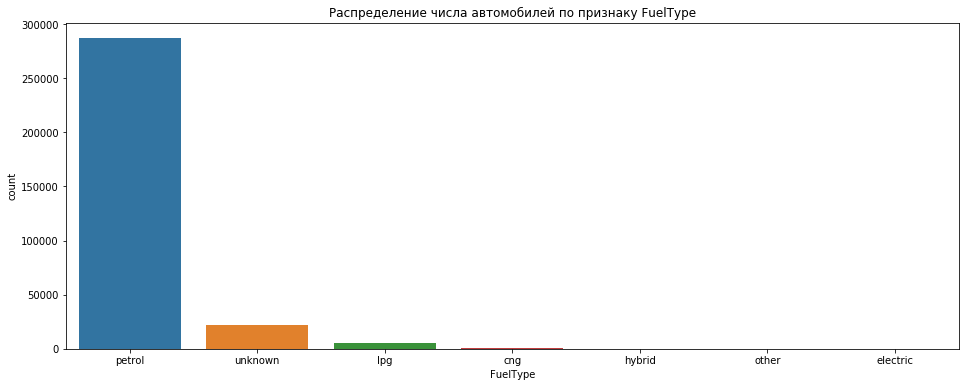

In [36]:
category_barplot('FuelType')

В основном, автомобили на бензине, другой вид топлива почти не встречается.

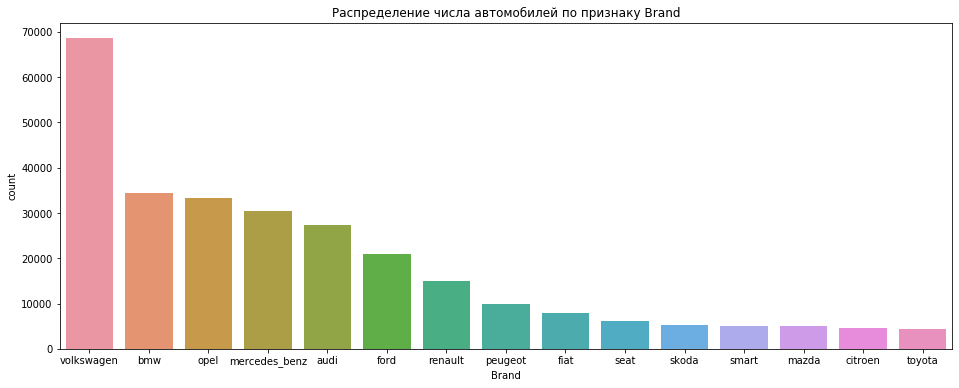

In [37]:
category_barplot('Brand', 15)

Любопытно, что большинство автомобилей марки "Volkswagen". Возможно, что это долгоживущие автомобили.

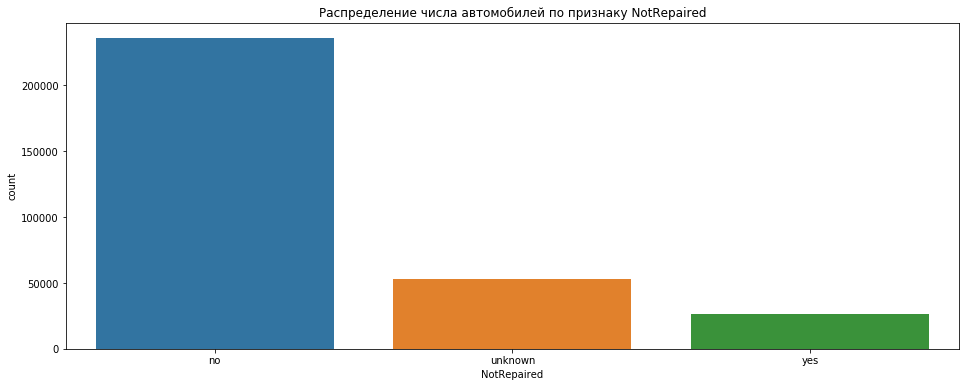

In [38]:
category_barplot('NotRepaired')

Большинство автомобилей подвергались ремонту, однако, есть и без него.

По каждой из категорий есть лидирующие значения, на что стоит обратить внимание при разбивке на подвыборки для валидации.

### Вывод

- Удалили столбцы DateCrawled, DateCreated, PostalCode.

- Много пропусков в колонке NotRepaired — была машина в ремонте или нет. Заменили пропуски в колонке NotRepaired на "unknown". Однако, для достижения более точного результата, **стоит поговорить с заказчиком и разработчиками**: может, информация по пропускам есть.

- Удалили артефакты в каждом признаке.

- В типе топлива petrol и gasoline объединили в одно значение - petrol.

- Фото нет ни у одного объекта. Удаляем этот признак.

## Обучение моделей

### Кодирование категориальных признаков

Так как у нас большое число элементов в категориальных признаках, применим порядковое кодирование. Применение OHE создаст очень большое число признаков.

In [39]:
display(df)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,unknown,125000,5,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,petrol,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...,...
351966,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes
351967,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no
351969,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
351970,9200,bus,1996,manual,102,transporter,150000,3,petrol,volkswagen,no


In [40]:
categories.append('RegistrationYear')
categories.append('RegistrationMonth')

encoder = OrdinalEncoder()

df[categories] = encoder.fit_transform(df[categories])

display(df)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
1,18300,2.00,39.00,1.00,190,228.00,125000,5.00,5.00,1.00,2.00
2,9800,6.00,32.00,0.00,163,117.00,125000,8.00,5.00,14.00,1.00
3,1500,5.00,29.00,1.00,75,116.00,150000,6.00,5.00,38.00,0.00
4,3600,5.00,36.00,1.00,69,101.00,90000,7.00,5.00,31.00,0.00
5,650,4.00,23.00,1.00,102,11.00,150000,10.00,5.00,2.00,2.00
...,...,...,...,...,...,...,...,...,...,...,...
351966,3200,4.00,32.00,1.00,225,140.00,150000,5.00,5.00,30.00,2.00
351967,1150,0.00,28.00,1.00,0,250.00,150000,3.00,5.00,24.00,0.00
351969,1199,1.00,28.00,0.00,101,106.00,125000,3.00,5.00,32.00,0.00
351970,9200,0.00,24.00,1.00,102,224.00,150000,3.00,5.00,38.00,0.00


In [41]:
numeric_features = ['Power', 'Kilometer']

### Выделение фичей и таргета, разбивка на трейн и тест, масштабирование

In [42]:
target = df['Price']
features = df.drop('Price', axis=1)

In [43]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)

print('Размер обучающих фич:', features_train.shape)
print('Размер тестовых фич:', features_test.shape)

Размер обучающих фич: (251994, 10)
Размер тестовых фич: (62999, 10)


In [44]:
mse_score = make_scorer(mean_squared_error, greater_is_better=False)

In [45]:
scaler = StandardScaler()
scaler.fit(features_train[numeric_features])

features_train[numeric_features] = scaler.transform(features_train[numeric_features])
features_test[numeric_features] = scaler.transform(features_test[numeric_features])

### Dummy модель

In [46]:
dr = DummyRegressor(strategy="mean")

dr.fit(features_train, target_train)
preds_dr = dr.predict(features_test)
rmse_dr = mean_squared_error(target_test, preds_dr) ** 0.5
print('RMSE_dr =', rmse_dr)

RMSE_dr = 4508.592991541791


### Линейная регрессия

In [47]:
start_time = datetime.now()

lr = LinearRegression()
hyper_params = [{'n_features_to_select': list(range(1, features.shape[1] + 1))}]

lr.fit(features_train, target_train)
rfe = RFE(lr)             

lr_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring = mse_score, 
                        cv = 5, 
                        verbose = 1,
                        return_train_score=True)      

lr_cv.fit(features_train, target_train)
print('Лучшие параметры:', lr_cv.best_params_)
print('RMSE = {:.2f}'.format(np.abs(lr_cv.best_score_) ** 0.5))

lr_time = datetime.now() - start_time

print('Время = {:}'.format(lr_time))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Лучшие параметры: {'n_features_to_select': 10}
RMSE = 3142.07
Время = 0:00:34.061702


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   33.7s finished


Посмотрим результат работы моделей на тестовой выборке:

In [48]:
def get_predictions_and_rmse(model, features, target):
    
    start_time = datetime.now()
    preds = model.predict(features)
    rmse = mean_squared_error(target, preds) ** 0.5
    print('RMSE = {:.2f}'.format(rmse))
    pred_time = datetime.now() - start_time
    print('Время предсказания = {:}'.format(pred_time))
    
    return rmse, preds, pred_time

In [49]:
rmse_lr_test, preds_lr, lr_pred_time = get_predictions_and_rmse(lr_cv, features_test, target_test)

RMSE = 3163.83
Время предсказания = 0:00:00.028686


### Дерево решений

In [50]:
dtr = DecisionTreeRegressor(random_state=12345)

parameters = {
    'max_depth' : range(1, 20, 1)
}

def find_best_model(X_train, y_train, model, parameters):
    start_time = datetime.now()
    grid = GridSearchCV(model, parameters, scoring=mse_score, cv=5)
    grid.fit(X_train, y_train)

    print('Лучшие параметры:', grid.best_params_)
    print('RMSE = {:.2f}'.format(np.abs(grid.best_score_) ** 0.5))
    dtr_or_rfr_time = datetime.now() - start_time
    print('Время = {:}'.format(dtr_or_rfr_time))
    return grid, np.abs(grid.best_score_) ** 0.5, dtr_or_rfr_time

In [51]:
grid_dtr, rmse_dtr_train, dtr_time = find_best_model(features_train, target_train, dtr, parameters)

Лучшие параметры: {'max_depth': 14}
RMSE = 1940.70
Время = 0:00:55.337022


In [52]:
rmse_dtr_test, preds_dtr, dtr_pred_time = get_predictions_and_rmse(grid_dtr, features_test, target_test)

RMSE = 1901.17
Время предсказания = 0:00:00.015866


### Случайный лес

In [53]:
rfr = RandomForestRegressor(random_state=12345)

parameters = {
    'n_estimators' : range(10, 30, 10),
    'max_depth' : range(1, 16, 3)
}


In [54]:
grid_rfr, rmse_rfr_train, rfr_time = find_best_model(features_train, target_train, rfr, parameters)

Лучшие параметры: {'max_depth': 13, 'n_estimators': 20}
RMSE = 1751.50
Время = 0:03:42.738740


In [55]:
rmse_rfr_test, preds_rfr, rfr_pred_time = get_predictions_and_rmse(grid_rfr, features_test, target_test)

RMSE = 1733.99
Время предсказания = 0:00:00.278529


### LightGBM

In [56]:
lgbm = LGBMRegressor(random_state=12345)

#params = {}
#params['learning_rate'] = 0.1
#params['boosting_type'] = 'gbdt'
#params['objective'] = 'gamma'
#params['metric'] = 'l1'
#params['sub_feature'] = 0.5
#params['num_leaves'] = 40
#params['min_data'] = 50
#params['max_depth'] = 30

#parameters = {
#    'learning_rate' :
#    'boosting_type' : 'gbdt'
#    'objective' : 'gamma'
#    'metric' : 'rmse'
#    'sub_feature' :
#    'num_leaves' :
#    'min_data' :  
#    'max_depth' : range(1, 16, 3)
#}

parameters = {
    'n_estimators': range(10, 30, 10), 
    'num_leaves': range(10,30,10),
    'max_depth' : range(1, 18, 3)
}


In [57]:
grid_lgbm, rmse_lgbm_train, lgbm_time = find_best_model(features_train, target_train, lgbm, parameters)

Лучшие параметры: {'max_depth': 10, 'n_estimators': 20, 'num_leaves': 20}
RMSE = 2218.14
Время = 0:03:07.346986


In [58]:
rmse_lgbm_test, preds_lgbm, lgbm_pred_time = get_predictions_and_rmse(grid_lgbm, features_test, target_test)

RMSE = 2228.19
Время предсказания = 0:00:00.104400


## Анализ моделей

In [59]:
data_finish = {'RMSE' : \
               [rmse_dr, rmse_lr_test, rmse_dtr_test, rmse_rfr_test, rmse_lgbm_test],
               'Время обучения' : \
               ['мгновение', lr_time, dtr_time, rfr_time, lgbm_time],
               'Время пресказания' : \
               ['мгновение', lr_pred_time, dtr_pred_time, rfr_pred_time, lgbm_pred_time]
}

#'Модель' : \
#               ['Dummy', 'Linear', 'DecisionTree', 'RandomForest', 'LightGBM']
frame = pd.DataFrame(data_finish, index = ['Dummy', 'Linear', 'DecisionTree', 'RandomForest', 'LightGBM'])

display(frame)

,RMSE,Время обучения,Время пресказания
Dummy,4508.59,мгновение,мгновение
Linear,3163.83,0:00:34.061702,0:00:00.028686
DecisionTree,1901.17,0:00:55.337022,0:00:00.015866
RandomForest,1733.99,0:03:42.738740,0:00:00.278529
LightGBM,2228.19,0:03:07.346986,0:00:00.104400


## Важность признаков

Посмотрим, какие признаки важны для lgbm модели.

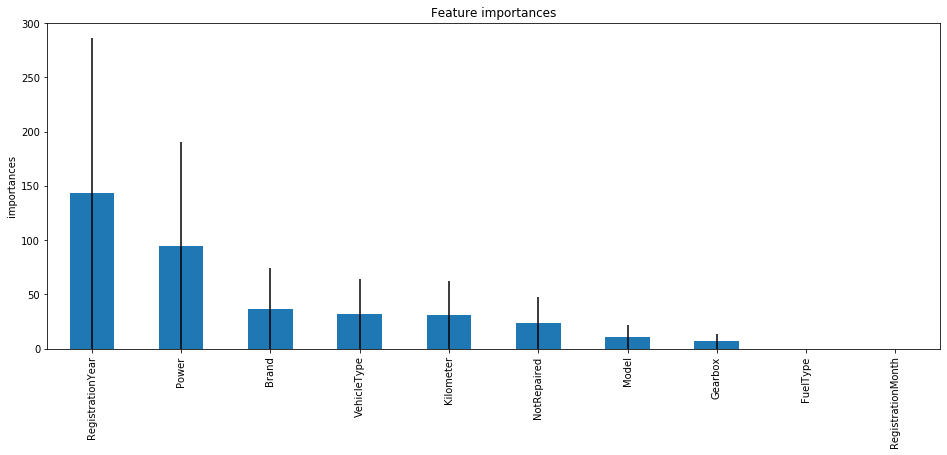

In [60]:
lgbm = LGBMRegressor(random_state=12345, n_estimators=20, max_depth=10, num_leaves=20, categorial_features=categories)
lgbm.fit(features_train, target_train)
importances = lgbm.feature_importances_

lgbm_importances = pd.Series(importances, index=features.columns).sort_values(ascending=False)

plt.figure(figsize=(16, 6)) 
lgbm_importances.plot.bar(yerr=lgbm_importances).set_title("Feature importances")
plt.ylabel('importances')
plt.show()

Решающим признаком является год регистрации. Возможно, разбивка на категории "ретро", "новая" действительно уточнит модель. Несущественными оказались тип топлива и месяц регистрации.

## Общий вывод

- На этапе предобработки обнаружено много пропусков в колонке NotRepaired — была машина в ремонте или нет. Заменили на "unknown". Однако, для достижения более точного результата, **стоит поговорить с заказчиком**: может, информация по пропускам есть. Удалили артефакты в каждом признаке.


- Обучили несколько моделей (Линейной регрессии, дерева решений, случайного леса и LightGBM). **Лучший результат RMSE** показала модель случайного леса (RMSE = 1751, learning_time = 3:42 мин) **лучшая скорость обучения** у линейной регрессии, но самый низкий RMSE (RMSE = 3142, learning_time = 34 с). **Быстрее всего предсказывает** модель решающего дерева, причём не намного хуже, чем случайного леса (RMSE = 1901,	prediction_time = 00.015 с). Предположительно, можно улучшить результат, если тщательнее подобрать параметры для LightGBM (пока не очень понимаю, как их лучше задавать, от каких значений отталкиваться. Решила пока сдать так, ибо дальше из идей только рандомно пробовать разное).
